# WGAN

## Import Necessary Packages

In [16]:
import numpy as np
from numpy.random import randn
from numpy.random import randint

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Reshape, Dropout, Input, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import fashion_mnist as mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Data & Preprocessing

In [17]:
def Input_Data():
    
    (Xtrain,_) , (_,_) = mnist.load_data()

    #     Xtrain = (Xtrain.astype('float32')/127.50) - 1
    Scaler = StandardScaler()

    Xtrain_shape = Xtrain.shape

    Xtrain = pd.DataFrame(Xtrain.reshape(Xtrain_shape[0],-1))
    Xtrain = Scaler.fit_transform(Xtrain)
    Xtrain = np.array(Xtrain)
    Xtrain = np.reshape(Xtrain,[Xtrain_shape[0],Xtrain_shape[1],Xtrain_shape[2]])
    Xtrain = Xtrain[...,np.newaxis]
    
    return Xtrain

## Define Model

### Generative Network - Discriminative Network - GAN

In [18]:
class GAN:   
    
    ### Generative Network
    def build_Gen(self,z_dim):
        
        init = tf.keras.initializers.RandomNormal(stddev=0.02)
        
        self.Gen = Sequential()
    
        self.Gen.add(Dense(128*7*7,input_dim=z_dim, kernel_initializer=init))
        self.Gen.add(LeakyReLU(0.2))
        self.Gen.add(Reshape((7,7,128)))
        
        self.Gen.add(Conv2DTranspose(64,kernel_size=3,strides=2, padding='same',kernel_initializer=init))
        self.Gen.add(BatchNormalization())
        self.Gen.add(LeakyReLU(alpha = 0.2))
        
        self.Gen.add(Conv2DTranspose(32,kernel_size=3, strides=2, padding='same',kernel_initializer=init))
        self.Gen.add(BatchNormalization())
        self.Gen.add(LeakyReLU(alpha = 0.2))
        
        self.Gen.add(Conv2DTranspose(1,kernel_size=3,strides=1, padding='same', activation = 'tanh',\
                                     kernel_initializer=init))
    
        return self
    
    
    ### Discriminative Network
    def build_Dis(self,data_size):
        
        init = tf.keras.initializers.RandomNormal(stddev=0.02)
        
        self.Dis = Sequential()
        
        self.Dis.add(Conv2D(32, kernel_size = 3, strides=2, input_shape = data_size, padding = 'same',kernel_initializer=init))
        self.Dis.add(LeakyReLU(alpha = 0.2))
        
        self.Dis.add(Conv2D(64, kernel_size = 3, strides=2, padding = 'same', kernel_initializer=init))
        self.Dis.add(BatchNormalization())
        self.Dis.add(LeakyReLU(alpha = 0.2))   

        self.Dis.add(Conv2D(128, kernel_size = 3, strides=2, padding = 'same', kernel_initializer=init))
        self.Dis.add(BatchNormalization())
        self.Dis.add(LeakyReLU(alpha = 0.2)) 
        
        self.Dis.add(Flatten())
        
        self.Dis.add(Dense(1))
#         self.Dis.add(LeakyReLU(alpha = 0.2))
        
        return self
    
    
    ### GAN Network
    def build_GAN(self):
        self.GAN = Sequential()
    
        self.GAN.add(self.Gen)
        self.GAN.add(self.Dis)
    
        return self

## Show Results

In [19]:

def show_results(model,z_dim):
    
    z = np.random.normal(0, 1, (16, z_dim))
    gen_imgs = model.Gen.predict(z)
    gen_imgs = 0.5*gen_imgs + 0.5

    fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)

    cnt=0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[cnt,:,:,0],cmap='gray')
            axs[i, j].axis('off')
            cnt+=1

    fig.show()



## Train Function

In [20]:
def Train(batch_size, Xtrain, z_dim, Info, Iters, Interval):
    
    Real_ideal = np.ones((batch_size,1))
    Fake_ideal = -np.ones((batch_size,1))
    
    for Iter in range(Iters):
        ## Discrimintive Network Training

        
        for k in range(5):
                 
            Xtrain_sample = Xtrain[np.random.randint(0,Xtrain.shape[0],batch_size)]
            Z = np.random.normal(0,1,(batch_size,z_dim))      
            Fake_Data_by_GenerativeNet = model.Gen.predict(Z)
            
            Dis_loss_Real = model.Dis.train_on_batch(Xtrain_sample,Real_ideal)
            Dis_loss_Fake = model.Dis.train_on_batch(Fake_Data_by_GenerativeNet,Fake_ideal)
        
            Dis_loss, Dis_accuracy = 0.5*(np.add(Dis_loss_Real,Dis_loss_Fake))
        
        
        ## Generative Network Training
        Z = np.random.normal(0,1,(batch_size,z_dim))
        Gen_loss = model.GAN.train_on_batch(Z,Fake_ideal)
        
        if (Iter+1) % Interval == 0:
            Info.losses.append((Dis_loss,Gen_loss))
            Info.accuracies.append(np.multiply(100,Dis_accuracy))
            Info.iteration_checks.append(Iter+1)
            
            print("%d [Dis_loss: %f , Dis_accuracy: %.2f] [Gen_loss: %f]" %
                  (Iter+1,Dis_loss,np.multiply(100.0,Dis_accuracy),Gen_loss))            
            
            show_results(model,z_dim)



## Wasserstein Loss

In [21]:
def Wasserstein_loss (y_True, y_Pred):
    return backend.mean(y_True*y_Pred)

## Main Program

10 [Dis_loss: -33.806736 , Dis_accuracy: 0.00] [Gen_loss: -0.450645]
20 [Dis_loss: -64.219639 , Dis_accuracy: 0.00] [Gen_loss: -4.173351]
30 [Dis_loss: -93.483822 , Dis_accuracy: 0.00] [Gen_loss: -13.900096]
40 [Dis_loss: -124.191475 , Dis_accuracy: 0.00] [Gen_loss: -30.556095]
50 [Dis_loss: -156.349487 , Dis_accuracy: 0.00] [Gen_loss: -51.729729]


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x0000016F536C70D0>
Traceback (most recent call last):
  File "C:\Users\adria\anaconda3\envs\pouya\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 536, in __del__
    gen_dataset_ops.delete_iterator(
  File "C:\Users\adria\anaconda3\envs\pouya\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1276, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


60 [Dis_loss: -191.674591 , Dis_accuracy: 0.00] [Gen_loss: -68.847366]
70 [Dis_loss: -228.959244 , Dis_accuracy: 0.00] [Gen_loss: -78.387436]



KeyboardInterrupt



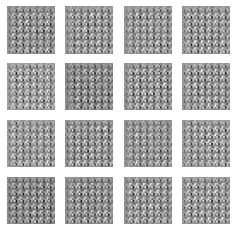

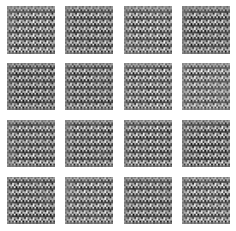

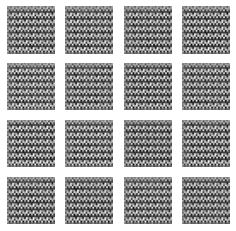

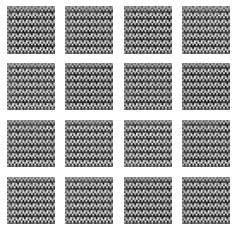

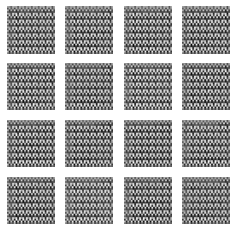

In [ ]:
class info:
    
    def __init__(self,losses=[],accuracies=[],iteration_checks=[]):
        
        self.losses = losses
        self.accuracies = accuracies
        self.iteration_checks = iteration_checks
        
Xtrain = Input_Data()
data_size = Xtrain.shape[1:]
batch_size = 64
z_dim = 100

model  = GAN()

model.build_Dis(data_size)
model.Dis.compile (loss = Wasserstein_loss,
               optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2 = 0.999),
               metrics = ['accuracy'])

model.build_Gen(z_dim)
# model.Gen.compile(loss = 'binary_crossentropy',
#                optimizer = Adam())

model.Dis.trainable = False

model.build_GAN()
model.GAN.compile(loss = Wasserstein_loss,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2 = 0.999))

    
Info = info([],[],[])
Train(batch_size, Xtrain, z_dim, Info, Iters = 20000, Interval = 10)